# Preparacion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==2.10.0

In [3]:
! pip install -q kaggle

In [ ]:
! pip install visualkeras

In [4]:
!nvidia-smi

Sat Nov  4 03:30:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import files

In [6]:
# el `kaggle.json`se saca de aca https://www.kaggle.com/settings/account
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simonappel","key":"90b10ee6a4438b41cbb4c37f13fa9ede"}'}

In [7]:
! mkdir ~/.kaggle/ && cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c inf-395-tarea-2

100% 4.66G/4.66G [02:15<00:00, 34.0MB/s]
100% 4.66G/4.66G [02:15<00:00, 36.9MB/s]


In [10]:
! mkdir ./data

In [11]:
! unzip inf-395-tarea-2.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/images/tacos/1023154.jpg  
  inflating: ./data/images/tacos/1023947.jpg  
  inflating: ./data/images/tacos/1026681.jpg  
  inflating: ./data/images/tacos/1030289.jpg  
  inflating: ./data/images/tacos/1033196.jpg  
  inflating: ./data/images/tacos/1036030.jpg  
  inflating: ./data/images/tacos/1042175.jpg  
  inflating: ./data/images/tacos/1044043.jpg  
  inflating: ./data/images/tacos/1058697.jpg  
  inflating: ./data/images/tacos/1059239.jpg  
  inflating: ./data/images/tacos/1059326.jpg  
  inflating: ./data/images/tacos/1066762.jpg  
  inflating: ./data/images/tacos/1070967.jpg  
  inflating: ./data/images/tacos/1073468.jpg  
  inflating: ./data/images/tacos/1075296.jpg  
  inflating: ./data/images/tacos/1085243.jpg  
  inflating: ./data/images/tacos/108529.jpg  
  inflating: ./data/images/tacos/1086014.jpg  
  inflating: ./data/images/tacos/108945.jpg  
  inflating: ./data/images/tacos/1089575.jpg  
  inflating

# Preprocesamiento de imagenes

In [12]:
# Numeric & Data Tabulation
import numpy as np
import pandas as pd

# Tensorflow's Keras

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn utils
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Visual Tools
from PIL import Image
import visualkeras
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Utils
import os

In [13]:
# Import csv & json data
train_index = pd.read_csv('./data/train.csv')
test_index = pd.read_csv('./data/test.csv')

dish_dict = pd.read_json('./data/dish_dict.json',typ='series')
food_categories_dict = pd.read_json('./data/food_categories_dict.json',typ='series')
hierarchy_dict = pd.read_json('./data/hierarchy_dict.json',typ='series')

## Head'ing data

In [ ]:
train_index.head()

,path,food_category,dish,classes
0,images/bibimbap/2857696.jpg,2,69,2 69
1,images/prime_rib/2280209.jpg,2,79,2 79
2,images/chicken_quesadilla/823085.jpg,2,60,2 60
3,images/bread_pudding/3141232.jpg,1,83,1 83
4,images/beignets/2139636.jpg,1,68,1 68


In [ ]:
train_index.describe()

,food_category,dish
count,75750.000000,75750.000000
mean,1.693069,50.000000
std,0.558335,29.154952
min,0.000000,0.000000
25%,1.000000,25.000000
50%,2.000000,50.000000
75%,2.000000,75.000000
max,2.000000,100.000000


In [ ]:
train_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   path           75750 non-null  object
 1   food_category  75750 non-null  int64 
 2   dish           75750 non-null  int64 
 3   classes        75750 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [ ]:
test_index.head()

,path
0,images/caprese_salad/820512.jpg
1,images/hamburger/2062556.jpg
2,images/lasagna/2381454.jpg
3,images/ceviche/1995.jpg
4,images/poutine/892377.jpg


In [ ]:
dish_dict.head()

0        foie_gras
1    club_sandwich
2     cheese_plate
3        cup_cakes
4     garlic_bread
dtype: object

In [ ]:
food_categories_dict.head()

0        salad
1      dessert
2    main_dish
dtype: object

In [ ]:
hierarchy_dict.head()

salad        {'0': 'seaweed_salad', '1': 'beet_salad', '2':...
dessert      {'0': 'apple_pie', '1': 'baklava', '2': 'beign...
main_dish    {'0': 'baby_back_ribs', '1': 'beef_carpaccio',...
dtype: object

## Visualization

<Axes: xlabel='categories', ylabel='count'>

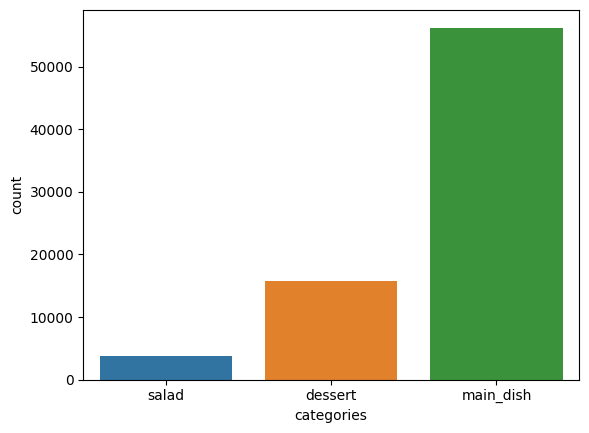

In [ ]:
# Se plotea la proporcion de categorias en la data.
grouped_categories = train_index.groupby("food_category").size()
data_fot_dataframe = {'categories': food_categories_dict, 'count': grouped_categories}

barplot_df = pd.DataFrame(data=data_fot_dataframe)
sns.barplot(barplot_df,x='categories',y='count')

In [ ]:
# Se plotea la proporción del tipo de comida en la data.
grouped_categories = train_index.groupby("dish").size()
grouped_categories.describe()

count    101.0
mean     750.0
std        0.0
min      750.0
25%      750.0
50%      750.0
75%      750.0
max      750.0
dtype: float64

(745.0, 755.0)

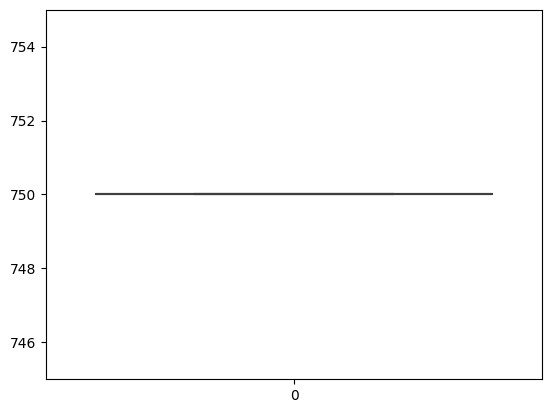

In [ ]:
boxplot = sns.boxplot(grouped_categories)
boxplot.set_ylim(745, 755)

In [ ]:
data_sample = train_index.sample(n=200,ignore_index=True)

In [ ]:
data_sample.head()

,path,food_category,dish,classes
0,images/tiramisu/1911646.jpg,1,53,1 53
1,images/grilled_salmon/1652824.jpg,2,73,2 73
2,images/pad_thai/817455.jpg,2,52,2 52
3,images/scallops/1787827.jpg,2,58,2 58
4,images/tiramisu/883020.jpg,1,53,1 53


In [ ]:
height = np.ndarray(shape=200)
width = np.ndarray(shape=200)

for i in range(data_sample.shape[0]):
  image_path = data_sample.iloc[i]["path"]
  x = Image.open('./data/'+image_path)
  height[i] = x.size[0]
  width[i] = x.size[1]

In [ ]:
shape_df = pd.DataFrame({'height': height,'width': width})
shape_df.describe()

,height,width
count,200.000000,200.000000
mean,495.325000,485.900000
std,47.489215,59.048911
min,289.000000,287.000000
25%,512.000000,512.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,512.000000,512.000000


# CSV Preprocessing

## Both category and dish

In [14]:
train_df = train_index.copy()

In [15]:
train_df = train_df.drop(["classes"],axis=1,inplace=False)

In [16]:
ohe_train = OneHotEncoder()
oh_encoded_data_cat = ohe_train.fit_transform(train_df["food_category"].to_numpy().reshape(-1, 1)).toarray()
oh_encoded_data_dish = ohe_train.fit_transform(train_df["dish"].to_numpy().reshape(-1, 1)).toarray()

In [17]:
ohe_cat_cols = ['OH_{}'.format(food_categories_dict[x]) for x in range(oh_encoded_data_cat.shape[1])]
ohe_dish_cols = ['OH_{}'.format(dish_dict[x]) for x in range(oh_encoded_data_dish.shape[1])]

In [18]:
ohe_df = pd.DataFrame(data=np.concatenate([oh_encoded_data_cat,oh_encoded_data_dish],axis=1),columns=[*ohe_cat_cols,*ohe_dish_cols])

In [19]:
train_df = train_df.drop(["food_category","dish"],axis=1,inplace=False)

In [20]:
train_df = pd.concat([train_df,ohe_df],axis=1)

## Multi-Label One-Hot

In [21]:
X_train_ml_ohe, X_val_ml_ohe, Y_train_ml_ohe, Y_val_ml_ohe = train_test_split(train_df["path"], train_df.loc[:, train_df.columns != 'path'], test_size=0.2, random_state=42)

In [ ]:
pd.concat([X_train_ml_ohe,Y_train_ml_ohe],axis=1)

,path,OH_salad,OH_dessert,OH_main_dish,OH_foie_gras,OH_club_sandwich,OH_cheese_plate,OH_cup_cakes,OH_garlic_bread,OH_gnocchi,...,OH_fried_rice,OH_french_onion_soup,OH_pho,OH_caprese_salad,OH_oysters,OH_baklava,OH_creme_brulee,OH_carrot_cake,OH_onion_rings,OH_caesar_salad
4327,images/chicken_curry/1686854.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65235,images/hot_dog/2817210.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70646,images/croque_madame/3373214.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74105,images/french_fries/1923345.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10576,images/lobster_roll_sandwich/147165.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,images/bread_pudding/3400381.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6265,images/risotto/2196168.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54886,images/chocolate_mousse/2534186.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,images/hot_dog/593867.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
x_train_images_open = list()

for fotopath in X_train_ml_ohe[:10000]:
  image = Image.open('./data/'+fotopath)
  x_train_images_open.append(np.asarray(image.resize((64,64)))/ 255)

x_val_images_open = list()

for fotopath in X_val_ml_ohe[:10000]:
  image = Image.open('./data/'+fotopath)
  x_val_images_open.append(np.asarray(image.resize((64,64)))/ 255)

In [23]:
X_train_clean_data = np.array(x_train_images_open)
X_val_clean_data = np.array(x_val_images_open)

In [24]:
category_train = Y_train_ml_ohe[:10000].to_numpy()[:,[0,1,2]]
dish_type_train = Y_train_ml_ohe[:10000].to_numpy()[:,3:]

category_val = Y_val_ml_ohe[:10000].to_numpy()[:,[0,1,2]]
dish_type_val = Y_val_ml_ohe[:10000].to_numpy()[:,3:]

# Model Definition

El modelo fue obtenido y levemente modificado de el [siguiente repositorio.](https://github.com/zhuxinqimac/B-CNN/blob/main/CIFAR_10_keras_medium_dynamic.py#L188)


In [26]:
def scheduler(epoch):
  learning_rate_init = 0.003
  if epoch > 40:
    learning_rate_init = 0.0005
  if epoch > 50:
    learning_rate_init = 0.0001
  return learning_rate_init

class LossWeightsModifier(Callback):
  def __init__(self, alpha, beta, gamma):
    self.alpha = alpha
    self.gamma = gamma
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 8:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.gamma, 0.1)
    if epoch == 18:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.gamma, 0.7)
    if epoch == 28:
      K.set_value(self.alpha, 0)
      K.set_value(self.gamma, 1)

In [27]:
def f1score(y,y_hat):
  true_pos = K.sum(K.round(K.clip(y*y_hat,0,1)))
  possible_pos = K.sum(K.round(K.clip(y,0,1)))
  pred_pos = K.sum(K.round(K.clip(y_hat,0,1)))

  precision = true_pos / (pred_pos + K.epsilon())
  recall = true_pos / (possible_pos + K.epsilon())

  return 2*(precision*recall)/(precision+recall+K.epsilon())

In [30]:
alpha = K.variable(value=0.98, dtype="float32", name="alpha")
gamma = K.variable(value=0.01, dtype="float32", name="gamma")

input = Input(shape=(64,64,3))

x=Conv2D(filters = 64, kernel_size= (3,3), padding = 'same', activation= 'relu')(input)
x=BatchNormalization()(x)
x=Conv2D(filters = 64, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2,2))(x)

x=Conv2D(filters = 128, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=BatchNormalization()(x)
x=Conv2D(filters = 128, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2,2))(x)

c1=Flatten()(x)
c1=Dense(256, activation='relu')(c1)
c1=BatchNormalization()(c1)
c1=Dropout(rate = 0.5)(c1)
c1_pred=Dense(3, activation='softmax',name="class_1")(c1)

x=Conv2D(filters = 256, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=BatchNormalization()(x)
x=Conv2D(filters = 256, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2,2))(x)

x=Conv2D(filters = 512, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=Dropout(rate = 0.5)(x)
x=BatchNormalization()(x)
x=Conv2D(filters = 512, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
x=MaxPool2D(pool_size=(2,2))(x)
x=BatchNormalization()(x)
x=Dropout(rate = 0.5)(x)

x=Flatten()(x)

x=Dense(1024, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(rate = 0.5)(x)
x=Dense(1024, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(rate = 0.5)(x)
output=Dense(101, activation='softmax', name="class_2")(x)

opt = SGD(learning_rate=0.003, momentum=0.9, nesterov=True)

model = Model(input,[c1_pred,output])
model.compile(optimizer = opt, loss ="categorical_crossentropy",loss_weights=[alpha, gamma], metrics = [f1score]) #

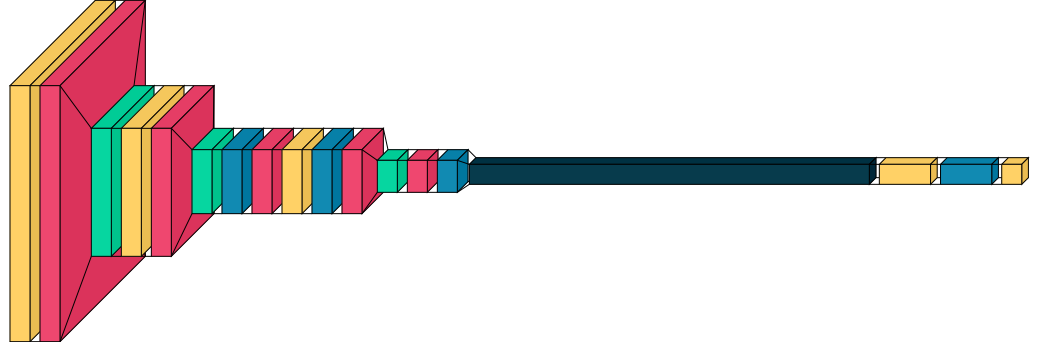

In [ ]:
visualkeras.layered_view(model)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 64, 64, 64)  256         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_17 (Conv2D)             (None, 64, 64, 64)   36928       ['batch_normalization_22[0]

In [33]:
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, gamma)
cbks = [change_lr, change_lw]

In [34]:
history = model.fit(
    x=X_train_clean_data,
    y=[category_train,dish_type_train],
    epochs = 60,
    batch_size=64,
    callbacks = cbks,
    validation_data=(X_val_clean_data,[category_val,dish_type_val]))

Epoch 1/60
157/157 [==============================] - 19s 47ms/step - loss: 1.0474 - class_1_loss: 1.0044 - class_2_loss: 6.3123 - class_1_f1score: 0.5860 - class_2_f1score: 7.2801e-04 - val_loss: 0.8137 - val_class_1_loss: 0.7811 - val_class_2_loss: 4.8166 - val_class_1_f1score: 0.7399 - val_class_2_f1score: 0.0000e+00 - lr: 0.0030
Epoch 2/60
157/157 [==============================] - 6s 35ms/step - loss: 0.7039 - class_1_loss: 0.6539 - class_2_loss: 6.3022 - class_1_f1score: 0.7293 - class_2_f1score: 0.0013 - val_loss: 0.7380 - val_class_1_loss: 0.7030 - val_class_2_loss: 4.9021 - val_class_1_f1score: 0.7402 - val_class_2_f1score: 0.0000e+00 - lr: 0.0030
Epoch 3/60
157/157 [==============================] - 6s 35ms/step - loss: 0.6392 - class_1_loss: 0.5882 - class_2_loss: 6.2745 - class_1_f1score: 0.7537 - class_2_f1score: 9.3141e-04 - val_loss: 0.6572 - val_class_1_loss: 0.6208 - val_class_2_loss: 4.8865 - val_class_1_f1score: 0.7410 - val_class_2_f1score: 0.0000e+00 - lr: 0.0030
E

# Inferencia

In [60]:
X_test_images = list()

for x in test_index.path:
  try:
    image = load_img('./data/'+x).resize((64,64))
    X_test_images.append(img_to_array(image)/255)
  except Exception as e:
    X_test_images.append(np.zeros((64, 64,3), dtype=np.uint8))

In [62]:
X_test_images = np.array(X_test_images)

In [63]:
predicted_values = model.predict(X_test_images)

790/790 [==============================] - 4s 5ms/step


In [72]:
predicted_cat_idx = predicted_values[0]
predicted_dish_idx = predicted_values[1]

predicted_cat_array = np.argmax(predicted_cat_idx, axis=1)
predicted_dish_array = np.argmax(predicted_dish_idx, axis=1)

In [83]:
combine_arrays = lambda x,y: str(x) +' '+ str(y)
combine_arrays_vec = np.vectorize(combine_arrays)

In [88]:
classes = combine_arrays_vec(predicted_cat_array,predicted_dish_array)

In [89]:
classes = pd.Series(classes)

In [90]:
final_data = pd.DataFrame({'path':test_index.path, 'classes':classes})

In [91]:
final_data

,path,classes
0,images/caprese_salad/820512.jpg,2 42
1,images/hamburger/2062556.jpg,2 95
2,images/lasagna/2381454.jpg,2 82
3,images/ceviche/1995.jpg,2 92
4,images/poutine/892377.jpg,2 54
...,...,...
25245,images/ravioli/2087725.jpg,2 97
25246,images/ice_cream/504131.jpg,1 63
25247,images/cannoli/1187751.jpg,2 12
25248,images/pancakes/477236.jpg,2 99


In [93]:
final_data.to_csv('/content/resultado.csv',index=False)